In [1]:
import os
os.chdir('..')

In [37]:
pwd

'/mnt/md1/user_victor/automatic_melody_harmonization'

In [38]:
import numpy as np
import torch 
from tonal import tonal_centroid, chord482note, chord962note, note2number
import matplotlib.pyplot as plt
from tqdm import tqdm

In [39]:
melody = np.load('./data/melody_baseline.npy')
chord = np.load('./data/number_96.npy')
chord_onehot = np.load('./data/onehot_96.npy')
length = np.load('./data/length.npy')

In [5]:
chord_onehot[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
def my_argmax(a):
    rows = np.where(a == a.max(axis=1)[:, None])[0]
    rows_multiple_max = rows[:-1][rows[:-1] == rows[1:]]
    my_argmax = a.argmax(axis=1)
    my_argmax[rows_multiple_max] = -1
    return my_argmax

# chord histogram entropy
def CHE_and_CC(chord_sequence, chord_num = 96):
    chord_index = np.argmax(chord_sequence, axis=1)

    chord_statistics = np.asarray([0 for i in range(chord_num)])
    for i in range(chord_index.shape[0]):
        chord_statistics[chord_index[i]] += 1

    CC = 0
    for i in chord_statistics:
        if i != 0:
            CC += 1
    sequence_length = chord_index.shape[0]
    chord_statistics = chord_statistics / sequence_length
    
    # calculate entropy
    H = 0
    H = sum([H + - p_i * np.log(p_i+1e-6) for p_i in chord_statistics])

    return H, CC

# chord tonal distance
def CTD(chord_sequence, chord_num = 96):
    chord_index = np.argmax(chord_sequence, axis=1)
    chord_note = []
    if chord_num == 96:
        for i in chord_index:
            chord_note.append(note2number(chord962note(i)))
    else:
        for i in chord_index:
            chord_note.append(note2number(chord482note(i)))

    y = 0

    for n in range(len(chord_note) - 1):
        y += np.sqrt(np.sum((np.asarray(tonal_centroid(chord_note[n+1])) - np.asarray(tonal_centroid(chord_note[n]))) ** 2))

    return y / (len(chord_note) - 1)

# Chord tone to non-chord tone ratio
def CTnCTR(melody_sequence, chord_sequence, chord_num = 96):
    chord_index = np.argmax(chord_sequence, axis=1)
    chord_note = []
    if chord_num == 96:
        for i in chord_index:
            chord_note.append(note2number(chord962note(i)))
    else:
        for i in chord_index:
            chord_note.append(note2number(chord482note(i)))

    melody_sequence = melody_sequence.reshape((melody_sequence.shape[0]*48, 12))
    melody_index = my_argmax(melody_sequence)
    melody_index = melody_index.reshape((-1, 48))

    c = 0
    p = 0
    n = 0
    for melody_m, chord_m in zip(melody_index, chord_note):
        for i in range(len(melody_m)):
            m = melody_m[i]
            if m != -1:
                if m in chord_m:
                    c += 1
                else:
                    n += 1
                    for j in range(i, len(melody_m)):
                        if melody_m[j] != -1:
                            if melody_m[j] != melody_m[i]:
                                if melody_m[j] in chord_m and abs(melody_m[i]-melody_m[j]) <= 2:
                                    p += 1
                                break
    if (c+n) == 0:
        return 0
    return (c+p)/(c+n)


# Pitch consonance score
def PCS(melody_sequence,chord_sequence, chord_num = 96):
    chord_index = np.argmax(chord_sequence, axis=1)
    chord_note = []
    if chord_num == 96:
        for i in chord_index:
            chord_note.append(note2number(chord962note(i)))
    else:
        for i in chord_index:
            chord_note.append(note2number(chord482note(i)))

    melody_sequence = melody_sequence.reshape((melody_sequence.shape[0] * 48, 12))
    melody_index = my_argmax(melody_sequence)
    melody_index = melody_index.reshape((-1, 48))

    score = 0
    count = 0
    for melody_m, chord_m in zip(melody_index, chord_note):
        for m in melody_m:
            if m != -1:
                for c in chord_m:
                    # unison, maj, minor 3rd, perfect 5th, maj, minor 6,
                    if abs(m - c) == 0 or abs(m - c) == 3 or abs(m - c) == 4 or abs(m - c) == 7 or abs(m - c) == 8 or abs(m - c) == 9 or abs(m - c) == 5:
                        if abs(m - c) == 5:
                            count += 1
                        else:
                            count += 1
                            score += 1
                    else:
                        count += 1
                        score += -1
    if count == 0:
        return 0
    return score/count

# melody_sequence-chord tonal distance

def MCTD(melody_sequence, chord_sequence, chord_num = 96):
    chord_index = np.argmax(chord_sequence, axis=1)
    chord_note = []
    if chord_num == 96:
        for i in chord_index:
            chord_note.append(note2number(chord962note(i)))
    else:
        for i in chord_index:
            chord_note.append(note2number(chord482note(i)))

    melody_sequence = melody_sequence.reshape((melody_sequence.shape[0] * 48, 12))
    melody_index = my_argmax(melody_sequence)
    melody_index = melody_index.reshape((-1, 48))

    y = 0
    count = 0
    for melody_m, chord_m in zip(melody_index, chord_note):
        for m in melody_m:
            if m != -1:
                y += np.sqrt(np.sum((np.asarray(tonal_centroid([m])) - np.asarray(tonal_centroid(chord_m)))) ** 2)
                count += 1
    if count == 0:
        return 0
    return y/count

In [27]:
i = 11000
tonal_distances = []

for i in tqdm(range(len(chord_onehot))):
    chord_seq = chord_onehot[i][:length[i]]

    chord_index = np.argmax(chord_seq, axis=1)
    # print('chord_index',chord_index)

    chord_note = []
    tonal_distance_by_seq = [0]

    for i in chord_index:
        chord_label = chord962note(i)
        chord_note.append(note2number(chord962note(i)))

    #     print('chord_label',chord_label)
    #     print('chord_note',note2number(chord962note(i)))

    for n in range(len(chord_note) - 1):
        tonal_distance = np.sqrt(np.sum((np.asarray(tonal_centroid(chord_note[n+1])) - np.asarray(tonal_centroid(chord_note[n]))) ** 2))
        tonal_distance_by_seq.append(tonal_distance)
    #     print(tonal_distance)
    
    tonal_distances.append(np.asarray(tonal_distance_by_seq))
#     fig, ax = plt.subplots()
#     ax.plot(tonal_distance_by_seq)

# tonal_distances = np.asarray(tonal_distances)



100%|██████████| 17430/17430 [00:24<00:00, 711.66it/s]


chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['F', 'A', 'C']
chord_note [5, 9, 0]
chord_label ['F', 'A', 'C']
chord_note [5, 9, 0]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['F', 'A', 'C']
chord_note [5, 9, 0]
chord_label ['F', 'A', 'C']
chord_note [5, 9, 0]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['F', 'A', 'C']
chord_note [5, 9, 0]
chord_label ['F', 'A', 'C']
chord_note [5, 9, 0]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]
chord_label ['G', 'B', 'D']
chord_note [7, 11, 2]
chord_label ['G', 'B', 'D']
chord_note [7, 11, 2]
chord_label ['G', 'B', 'D']
chord_note [7, 11, 2]
chord_label ['G', 'B', 'D']
chord_note [7, 11, 2]
chord_label ['C', 'E', 'G']
chord_note [0, 4, 7]


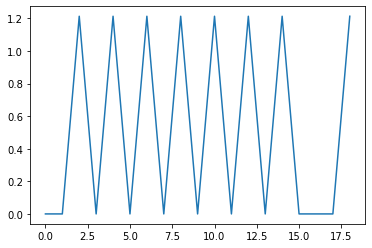

In [36]:
i = 1
tonal_distances = []
chord_seq = chord_onehot[i][:length[i]]
chord_index = np.argmax(chord_seq, axis=1)
# print('chord_index',chord_index)

chord_note = []
tonal_distance_by_seq = [0]

for i in chord_index:
    chord_label = chord962note(i)
    chord_note.append(note2number(chord962note(i)))

    print('chord_label',chord_label)
    print('chord_note',note2number(chord962note(i)))

for n in range(len(chord_note) - 1):
    tonal_distance = np.sqrt(np.sum((np.asarray(tonal_centroid(chord_note[n+1])) - np.asarray(tonal_centroid(chord_note[n]))) ** 2))
    tonal_distance_by_seq.append(tonal_distance)
#     print(tonal_distance)

tonal_distances.append(np.asarray(tonal_distance_by_seq))
fig, ax = plt.subplots()
ax.plot(tonal_distance_by_seq)

# tonal_distances = np.asarray(tonal_distances)


In [18]:
len(tonal_distances)

2

In [28]:
for i in tqdm(range(len(chord_onehot))):
    tonal_distances[i] = np.pad(tonal_distances[i], (0, 272 - tonal_distances[i].shape[0]), 'constant', constant_values = (0, 0))
tonal_distances = np.asarray(tonal_distances)


100%|██████████| 17430/17430 [00:00<00:00, 24976.16it/s]


In [33]:
tonal_distances = np.expand_dims(tonal_distances, axis=2)
tonal_distances.shape

(17430, 272, 1)

In [34]:
np.save('./data/CTD_framewise',tonal_distances)

In [ ]:
CTD = np.load('./data/CTD_framewise')